In [1]:
import tensorflow.keras as k
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Activation,UpSampling2D,Input,add
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
with open('data.pickle','rb') as f:
  data=pickle.load(f)

In [52]:
x_train=data
print(x_train.shape)
# plt.imshow(x_train[100],cmap='gray')

(5666, 240, 320, 1)


In [4]:
# function to create blur dataset

def make_blur(data_):

  # creating blur filter
  n=data_.shape[-1]
  blur_filter=np.zeros((n,n))
  print(n)
  print(blur_filter.shape)
  for i in range(1,n-1):
    blur_filter[i,[i-1,i,i+1]]=[1,1,1]
  blur_filter[0,[0,1]]=1
  blur_filter[n-1,[n-1,n-2]]=1

  # making new blured data
  new_data=[]
  for img in data_:
    new_data.append(np.dot(img,blur_filter)/3)
  new_data=np.array(new_data)

  # visualizing blured images
  # plt.figure(figsize=(20,20))
  # plt.subplot(121)
  # plt.imshow(data_[0],cmap='gray')
  # plt.subplot(122)
  # plt.imshow(np.dot(data_[0],blur_filter)/3,cmap='gray')

  return new_data

In [48]:
data_=make_blur(data)

In [6]:
data=np.expand_dims(data,axis=-1)
data_=np.expand_dims(data_,axis=-1)

In [7]:
print(data.shape)
print(data_.shape)

(5666, 240, 320, 1)
(5666, 240, 320, 1)


In [15]:
(data2,_),(_,_)=k.datasets.fashion_mnist.load_data()

In [53]:
data2_=make_blur(data2)

In [18]:
data2=np.expand_dims(data2,axis=-1)
data2_=np.expand_dims(data2_,axis=-1)
print(data2_.shape)

(60000, 28, 28, 1)


In [19]:
# creating autoencoder to predict hight resolution image

input=Input(data2.shape[1:])
l1=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(input)
l2=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)

l4=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)

l7=Conv2D(256,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6) # bottel nect layer. with latent features

encoder=Model(inputs=input,outputs=l7) # encoder part of autoencoder

#__________________________________________________________________________#

l8=UpSampling2D()(l7)
l9=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l5,l10])

l12=UpSampling2D()(l11)
l13=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l2,l14])

output=Conv2D(1,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15) # output of decoder.

#___________________________________________________________________________#

autoencoder=Model(input,output) # autoencoder for image enhancement 
autoencoder.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)   0           conv2d_11[0][0]                  
_______________________________________________________________________________________

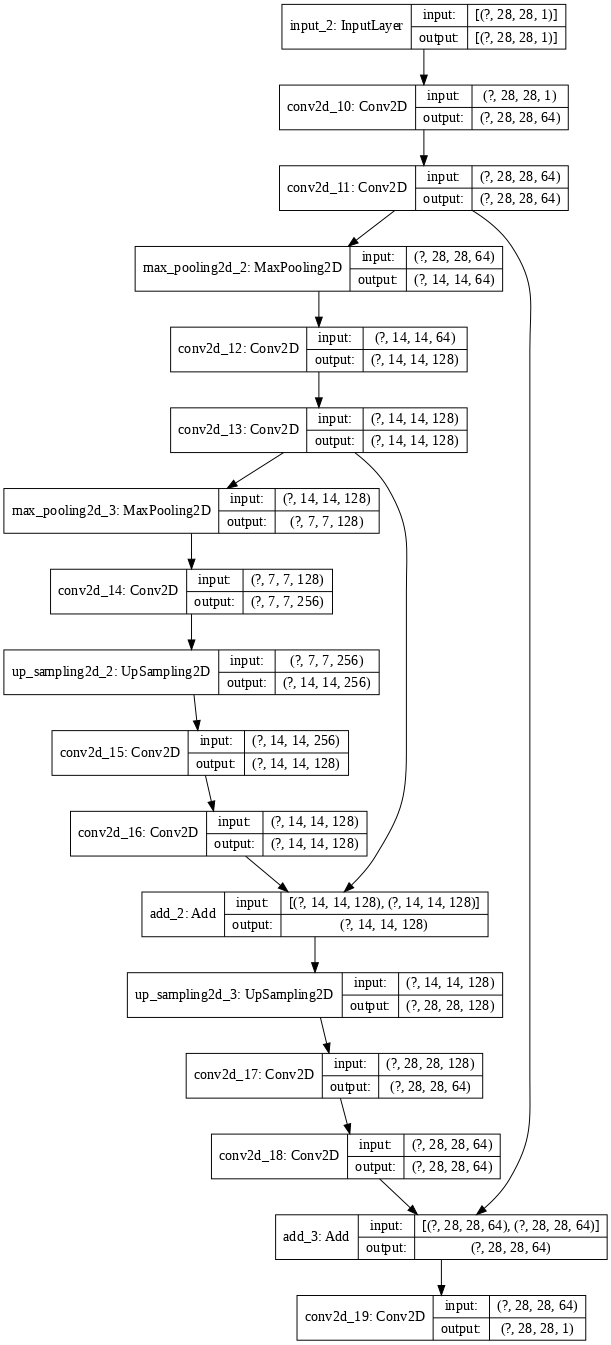

In [20]:
# visualizing the model 
k.utils.plot_model(autoencoder,to_file='model.png',show_shapes=True,show_layer_names=True,dpi=70)

In [37]:
# compiling model using adam optimizer and 'mae' loss
autoencoder.compile('rmsprop',loss='mae',metrics=['accuracy'])

In [47]:
# training model
history=autoencoder.fit(data2_,data2,epochs=3,validation_split=.1)

In [39]:
pred=autoencoder.predict(data2_[:10])

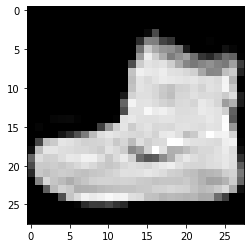

In [43]:
plt.imshow(np.resize(pred[0],(28,28)),cmap='gray')

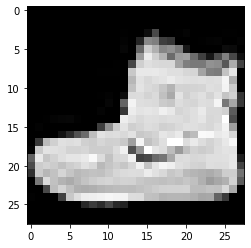

In [46]:
plt.imshow(np.resize(data2[0],(28,28)),cmap='gray')